# Data Analysis Assignment 4
**Group:**


In [2]:
# Initial setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages #from https://www.geeksforgeeks.org/save-multiple-matplotlib-figures-in-single-pdf-file-using-python/
import seaborn as sns
import csv
import gc

# Configure plotting
plt.rcParams.update({
    'figure.figsize': [12, 8],
    'figure.dpi': 150,
    'figure.autolayout': True,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'font.size': 12
})

pathRaw = "./data_raw/"
pathFilter = "./data_filtered/"
pathProcessd = "./data_processed/"
pathVisuRaw = "./visu_raw"

files = [f"system-{number}.csv" for number in range(1, 20)]
# overrride (selection)
#files = files[0:8]

# Systems 8, 11 and 17 do not have sys-thermal readings !
remove_entries = [7,10,16]
files = [item for index, item in enumerate(files) if index not in remove_entries]
# test 
print(files)


sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)
#np.random.seed(42)

['system-1.csv', 'system-2.csv', 'system-3.csv', 'system-4.csv', 'system-5.csv', 'system-6.csv', 'system-7.csv', 'system-9.csv', 'system-10.csv', 'system-12.csv', 'system-13.csv', 'system-14.csv', 'system-15.csv', 'system-16.csv', 'system-18.csv', 'system-19.csv']


### Loading and Filtering
Files are fetched from directory and prefiltering for columns of interst.

Processing timestamps to datetime for usage in timeseries (and usability).

Done via a function to execute for every file separately and be able to pipe if necessary.

Returning the dataframe could be either dropped or caught by either a container or piped into the next function.

In [3]:
def load_system_data(file_dir: str, file_name: str) -> pd.DataFrame :
    """Load and prepare test system performance data.
    
    Parameters
    ----------
    file_dir : str
        Path to the CSV data file location (directory)
    file_name : str
        Name of the specified CSV file
    
    Additional outputs
    saves filtered data into dir "./data_filtered"
    
    Returns
    -------
    pd.DataFrame
        Raw dataframe with columns:
        - datetime (index)
        - load-15m
        - memory_used_pct
        - cpu-user
        - cpu-system
        - sys-thermal
        - sys-interrupt-rate
        - server-up
        - disk-io-time
    """
    file_path = file_dir + file_name

    df = pd.read_csv(file_path, delimiter = ",",usecols=["timestamp",
                                                         "load-15m",
                                                         "sys-mem-available",
                                                         "sys-mem-total",
                                                         "cpu-user",
                                                         "cpu-system",
                                                         "sys-thermal",
                                                         "sys-interrupt-rate",
                                                         "server-up",
                                                         "disk-io-time"]) # Read in data with columns
    

    
    df['datetime'] = pd.to_datetime(df['timestamp'], unit = 's', errors = 'coerce') # Create datetime from timestamp
    
    df.set_index('datetime', inplace=True) # Set datetime as index

    df['memory_used_pct'] = (1 - df['sys-mem-available']/df['sys-mem-total']) * 100 # Memory usage calculation
    df.drop(["timestamp","sys-mem-available","sys-mem-total"], axis=1, inplace=True) # Drop unneccessary data
    
    df.to_csv(pathFilter+file_name, index=True)
    
    return df

# to generate the filtered files -> visualization and analysis will load and use them separately (to minimoze RAM usage)
for i in files:
    this = load_system_data(pathRaw, i)
    print(i, " : ------------------------ \n", this.head(), "\n", this.tail())
#del this
#gc.collect()

system-1.csv  : ------------------------ 
                      load-15m  sys-interrupt-rate  sys-thermal  disk-io-time  \
datetime                                                                       
1970-01-01 00:00:00      0.18              970.15         1.60        0.0076   
1970-01-01 00:00:30      0.18             1081.55         0.00        0.0060   
1970-01-01 00:01:00      0.18              995.40         0.00        0.0134   
1970-01-01 00:01:30      0.18             1010.65         0.00        0.0078   
1970-01-01 00:02:00      0.17              971.30         1.55        0.0066   

                     cpu-system  cpu-user  server-up  memory_used_pct  
datetime                                                               
1970-01-01 00:00:00      0.0240    0.0405          2         8.005350  
1970-01-01 00:00:30      0.0270    0.0475          2         7.995124  
1970-01-01 00:01:00      0.0255    0.0260          2         8.001982  
1970-01-01 00:01:30      0.0305    0

### Visualizing Raw (filtered) 

Loading filtered files or reading passed dataframe and visualizing the data. 

Function called with a DataFrame.


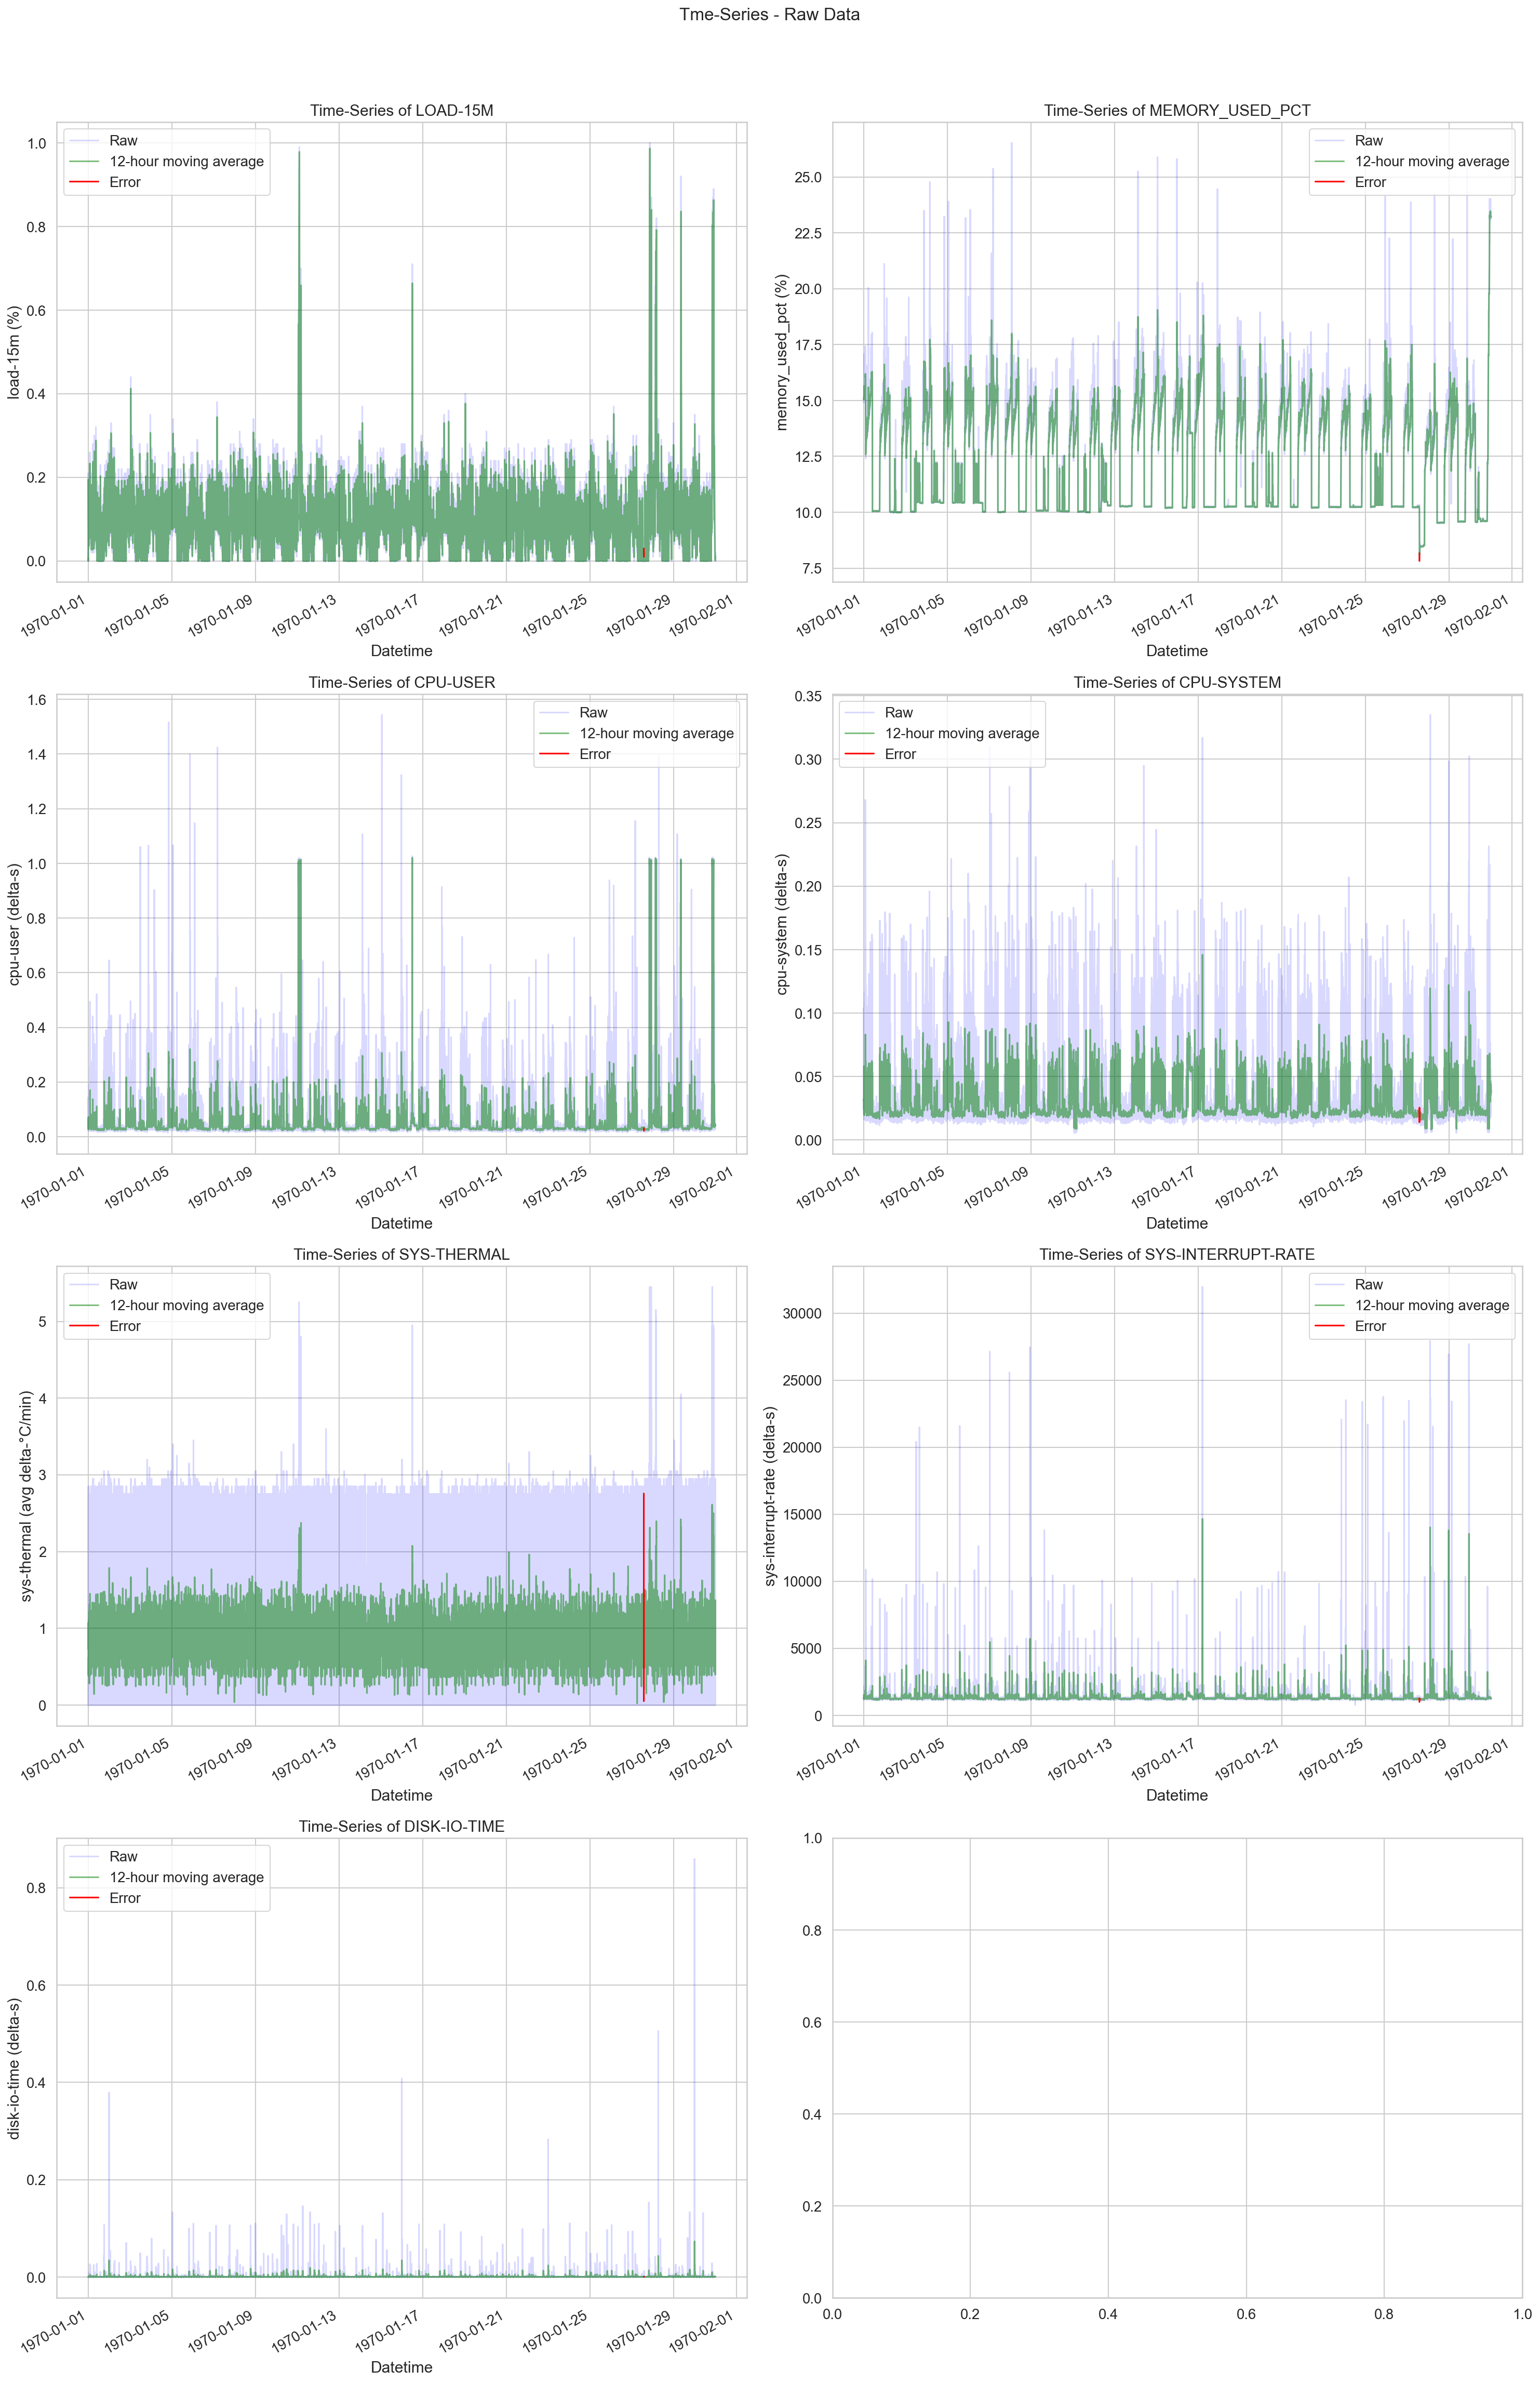

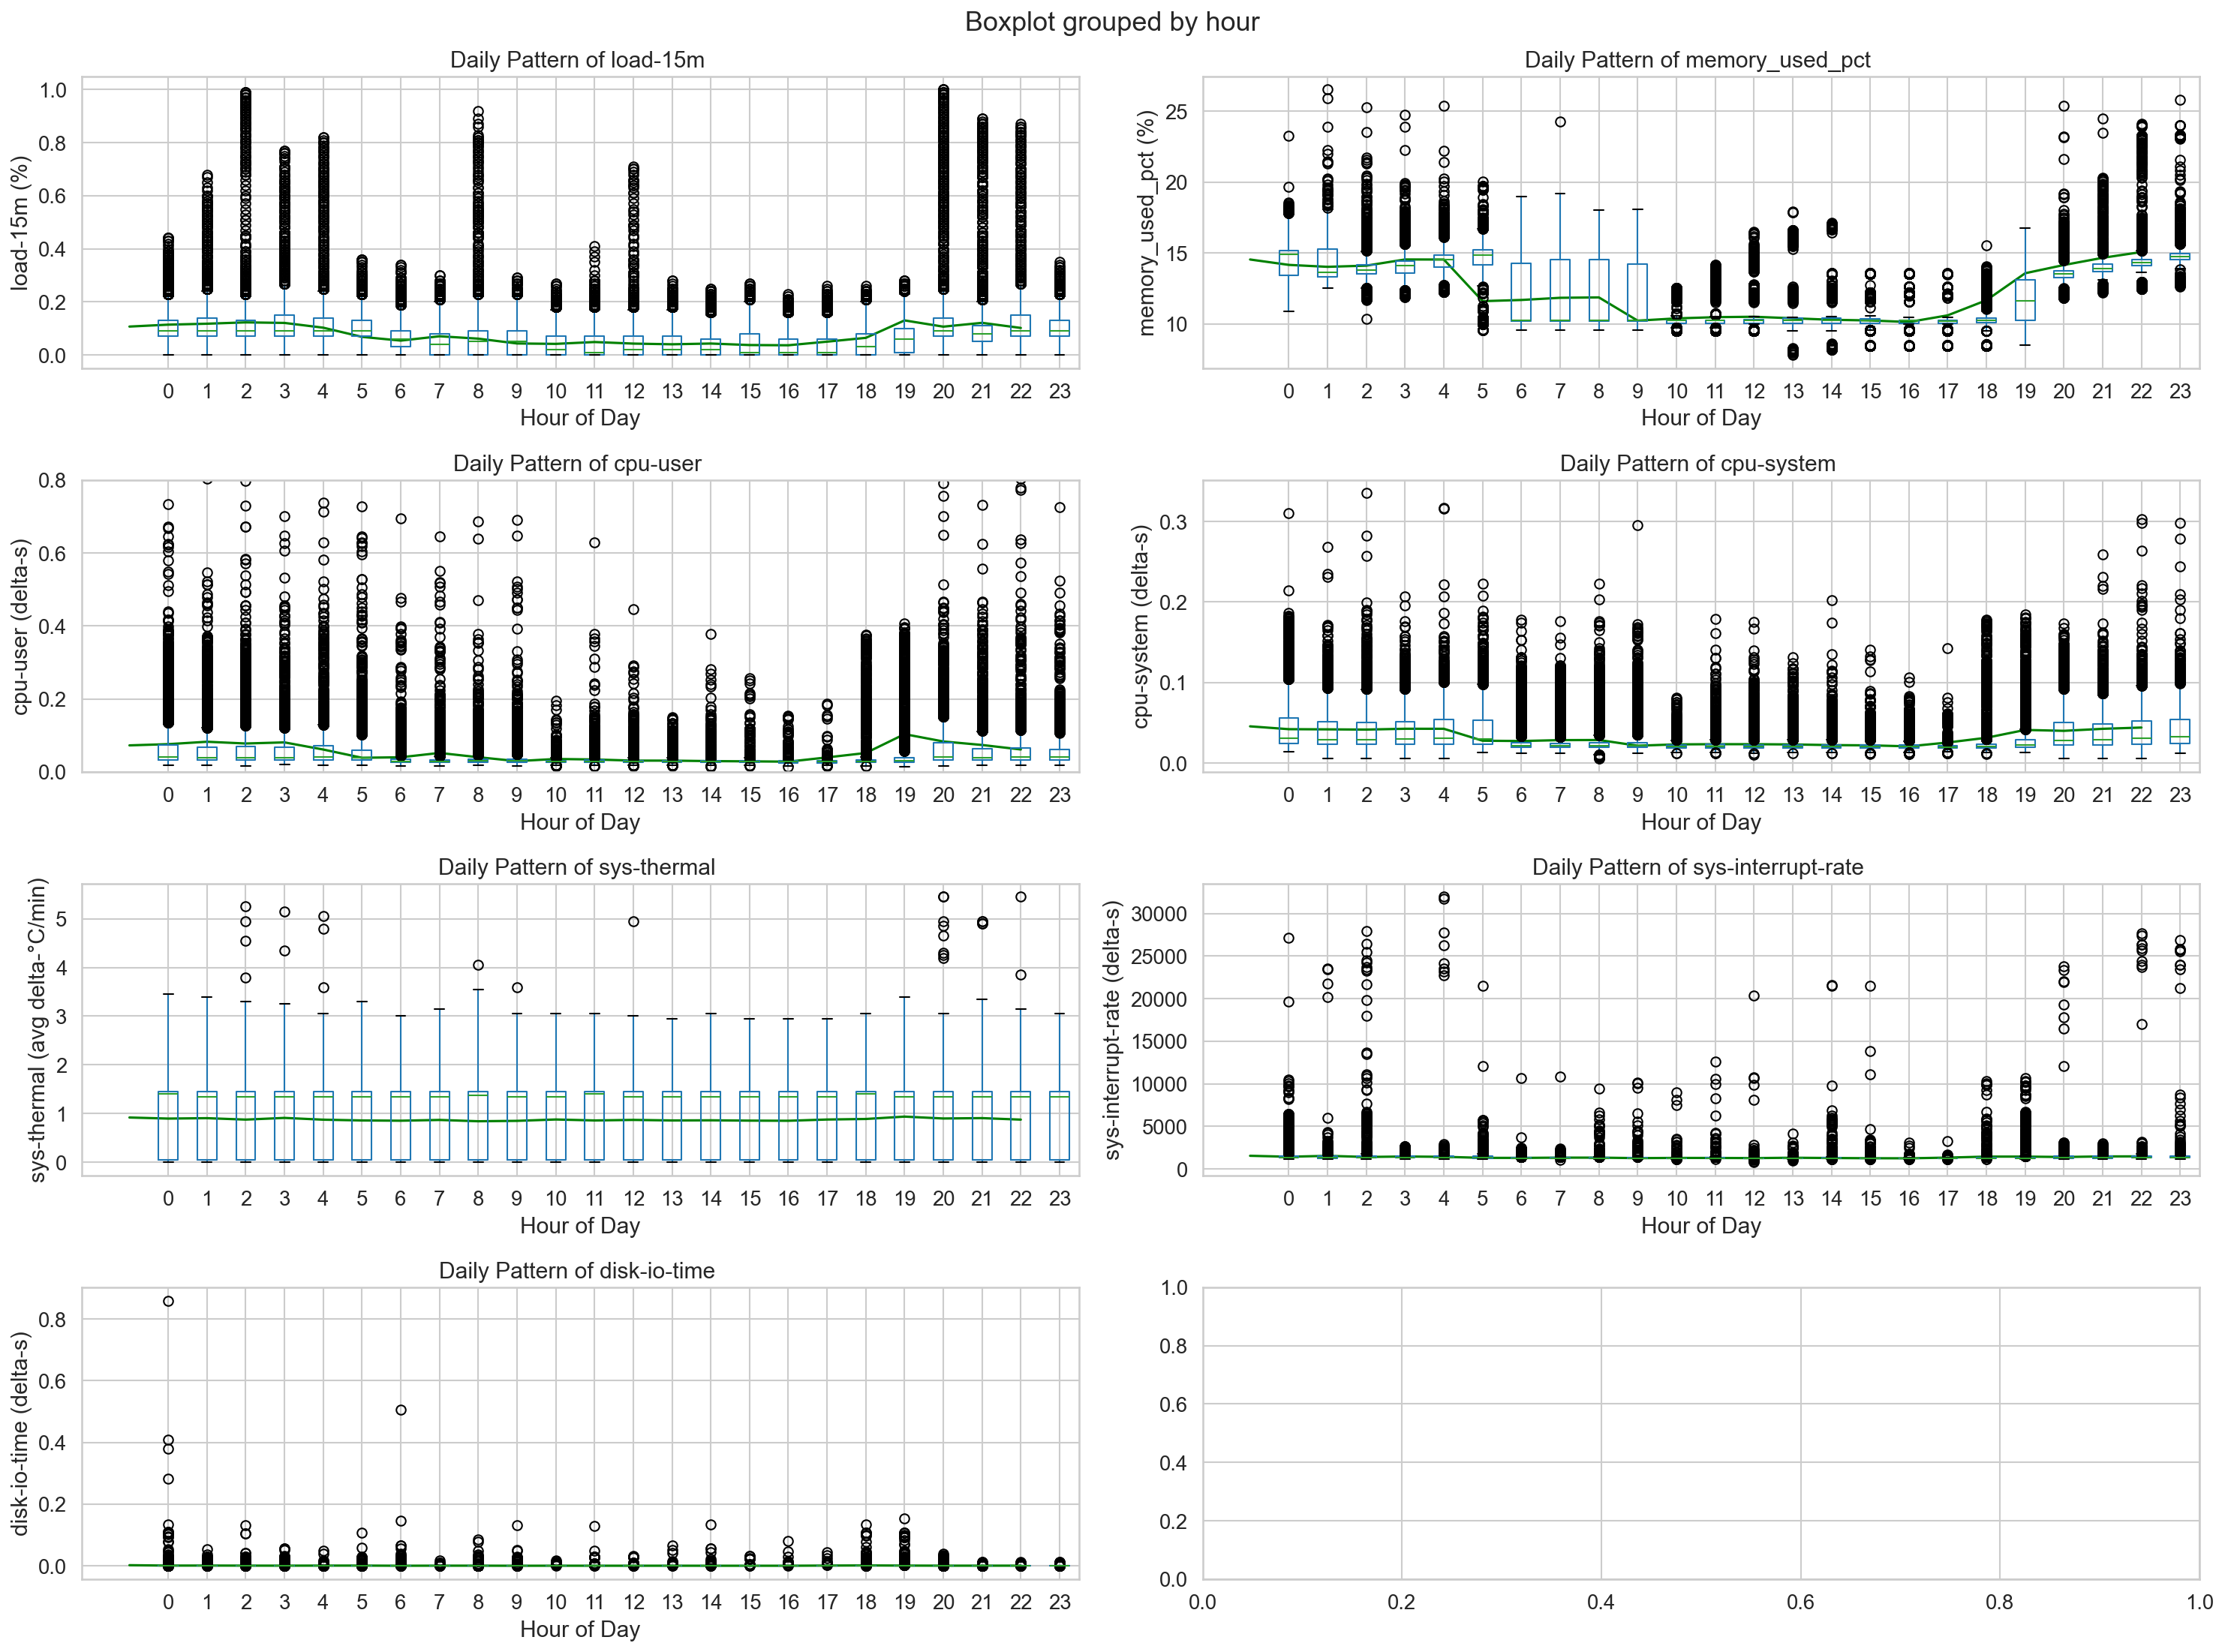

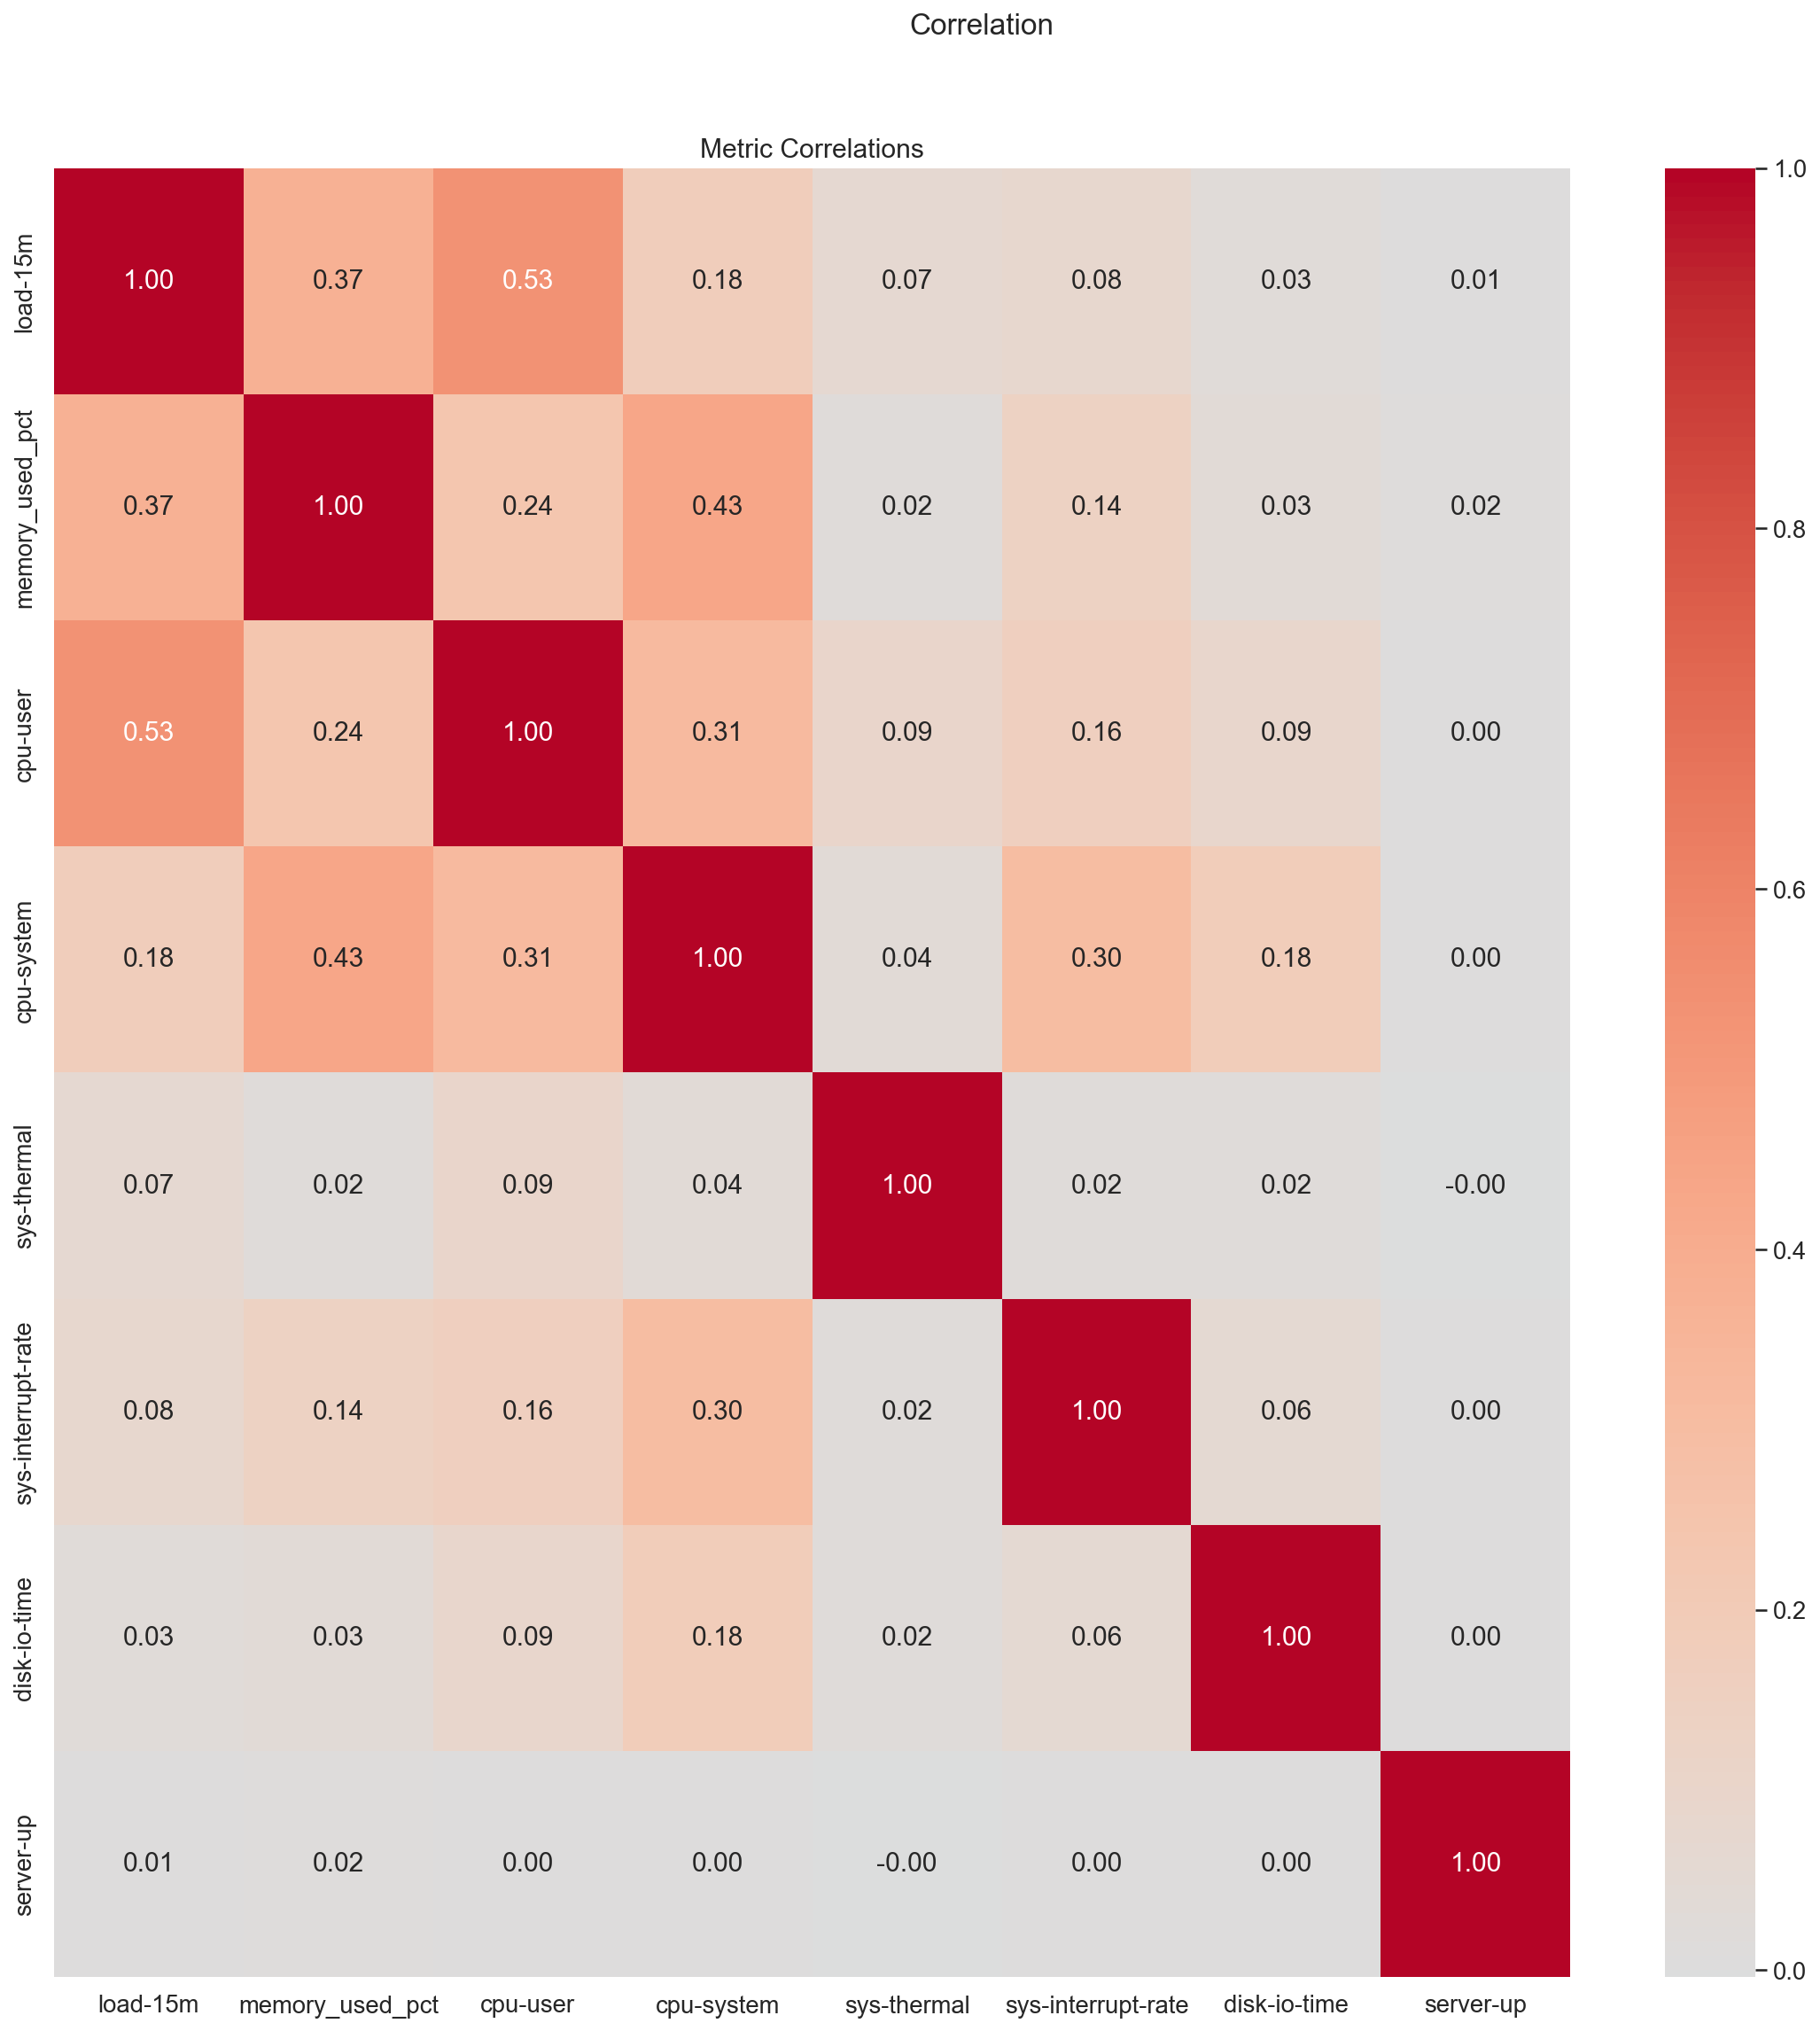

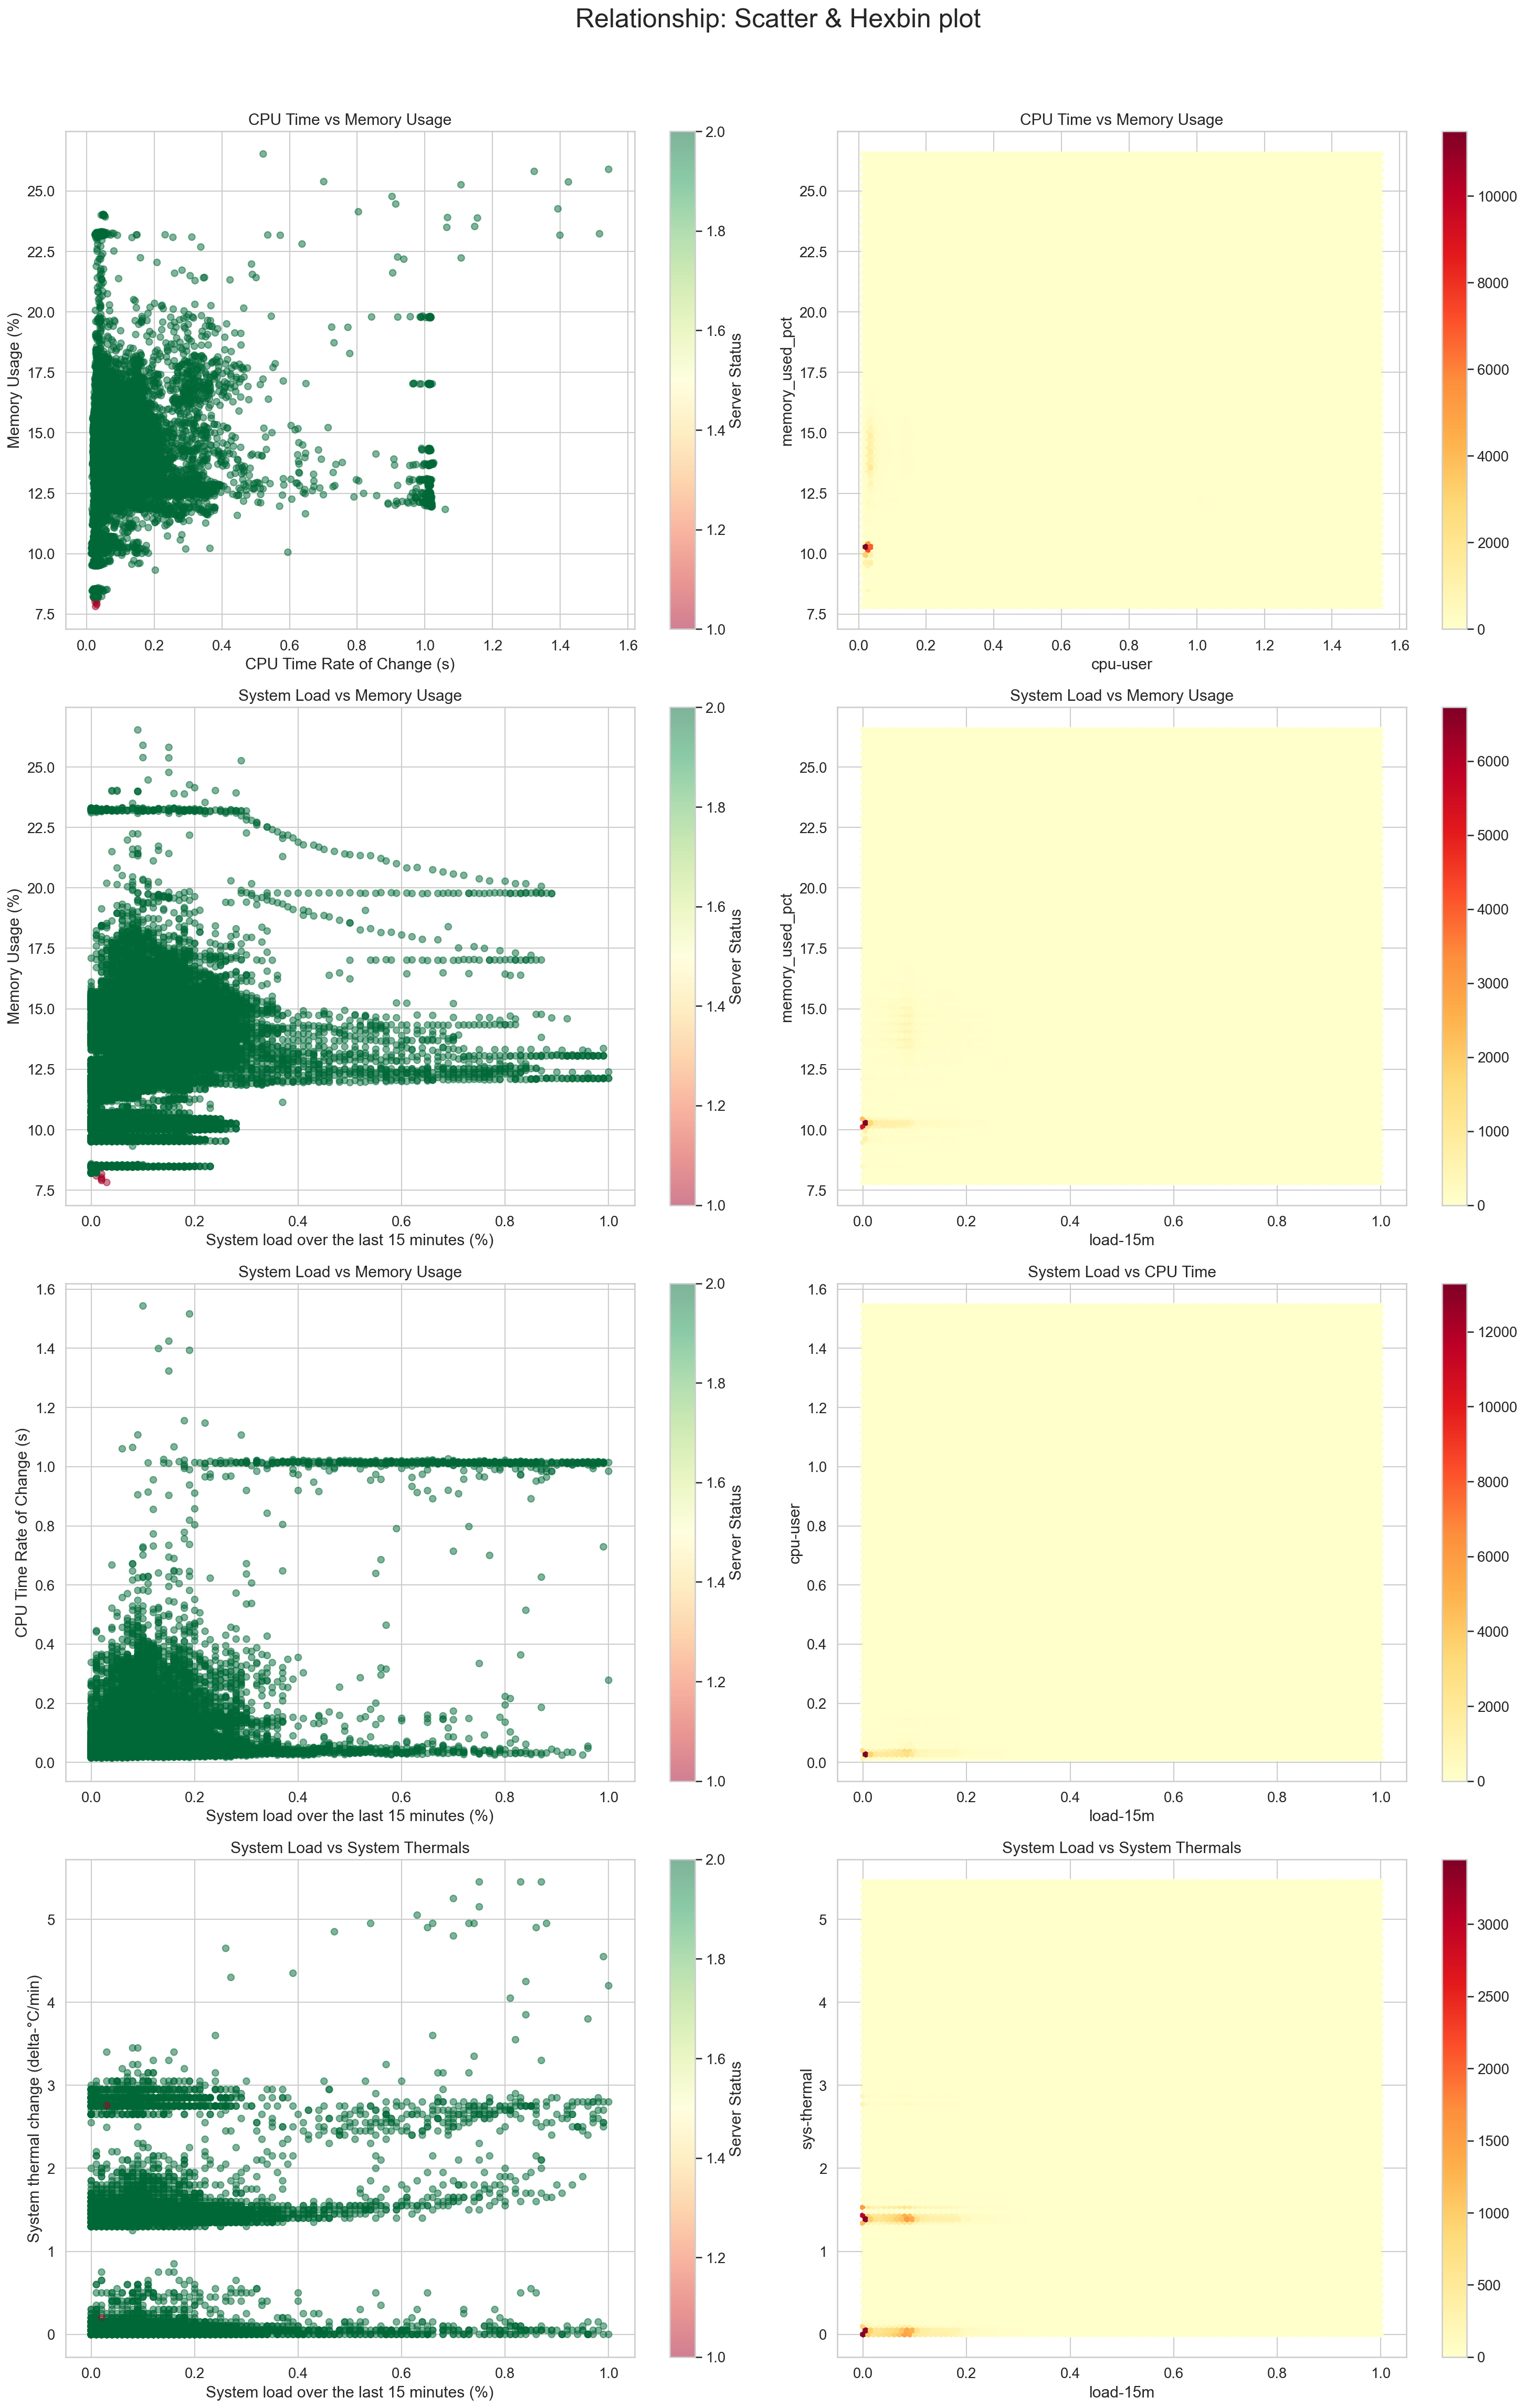

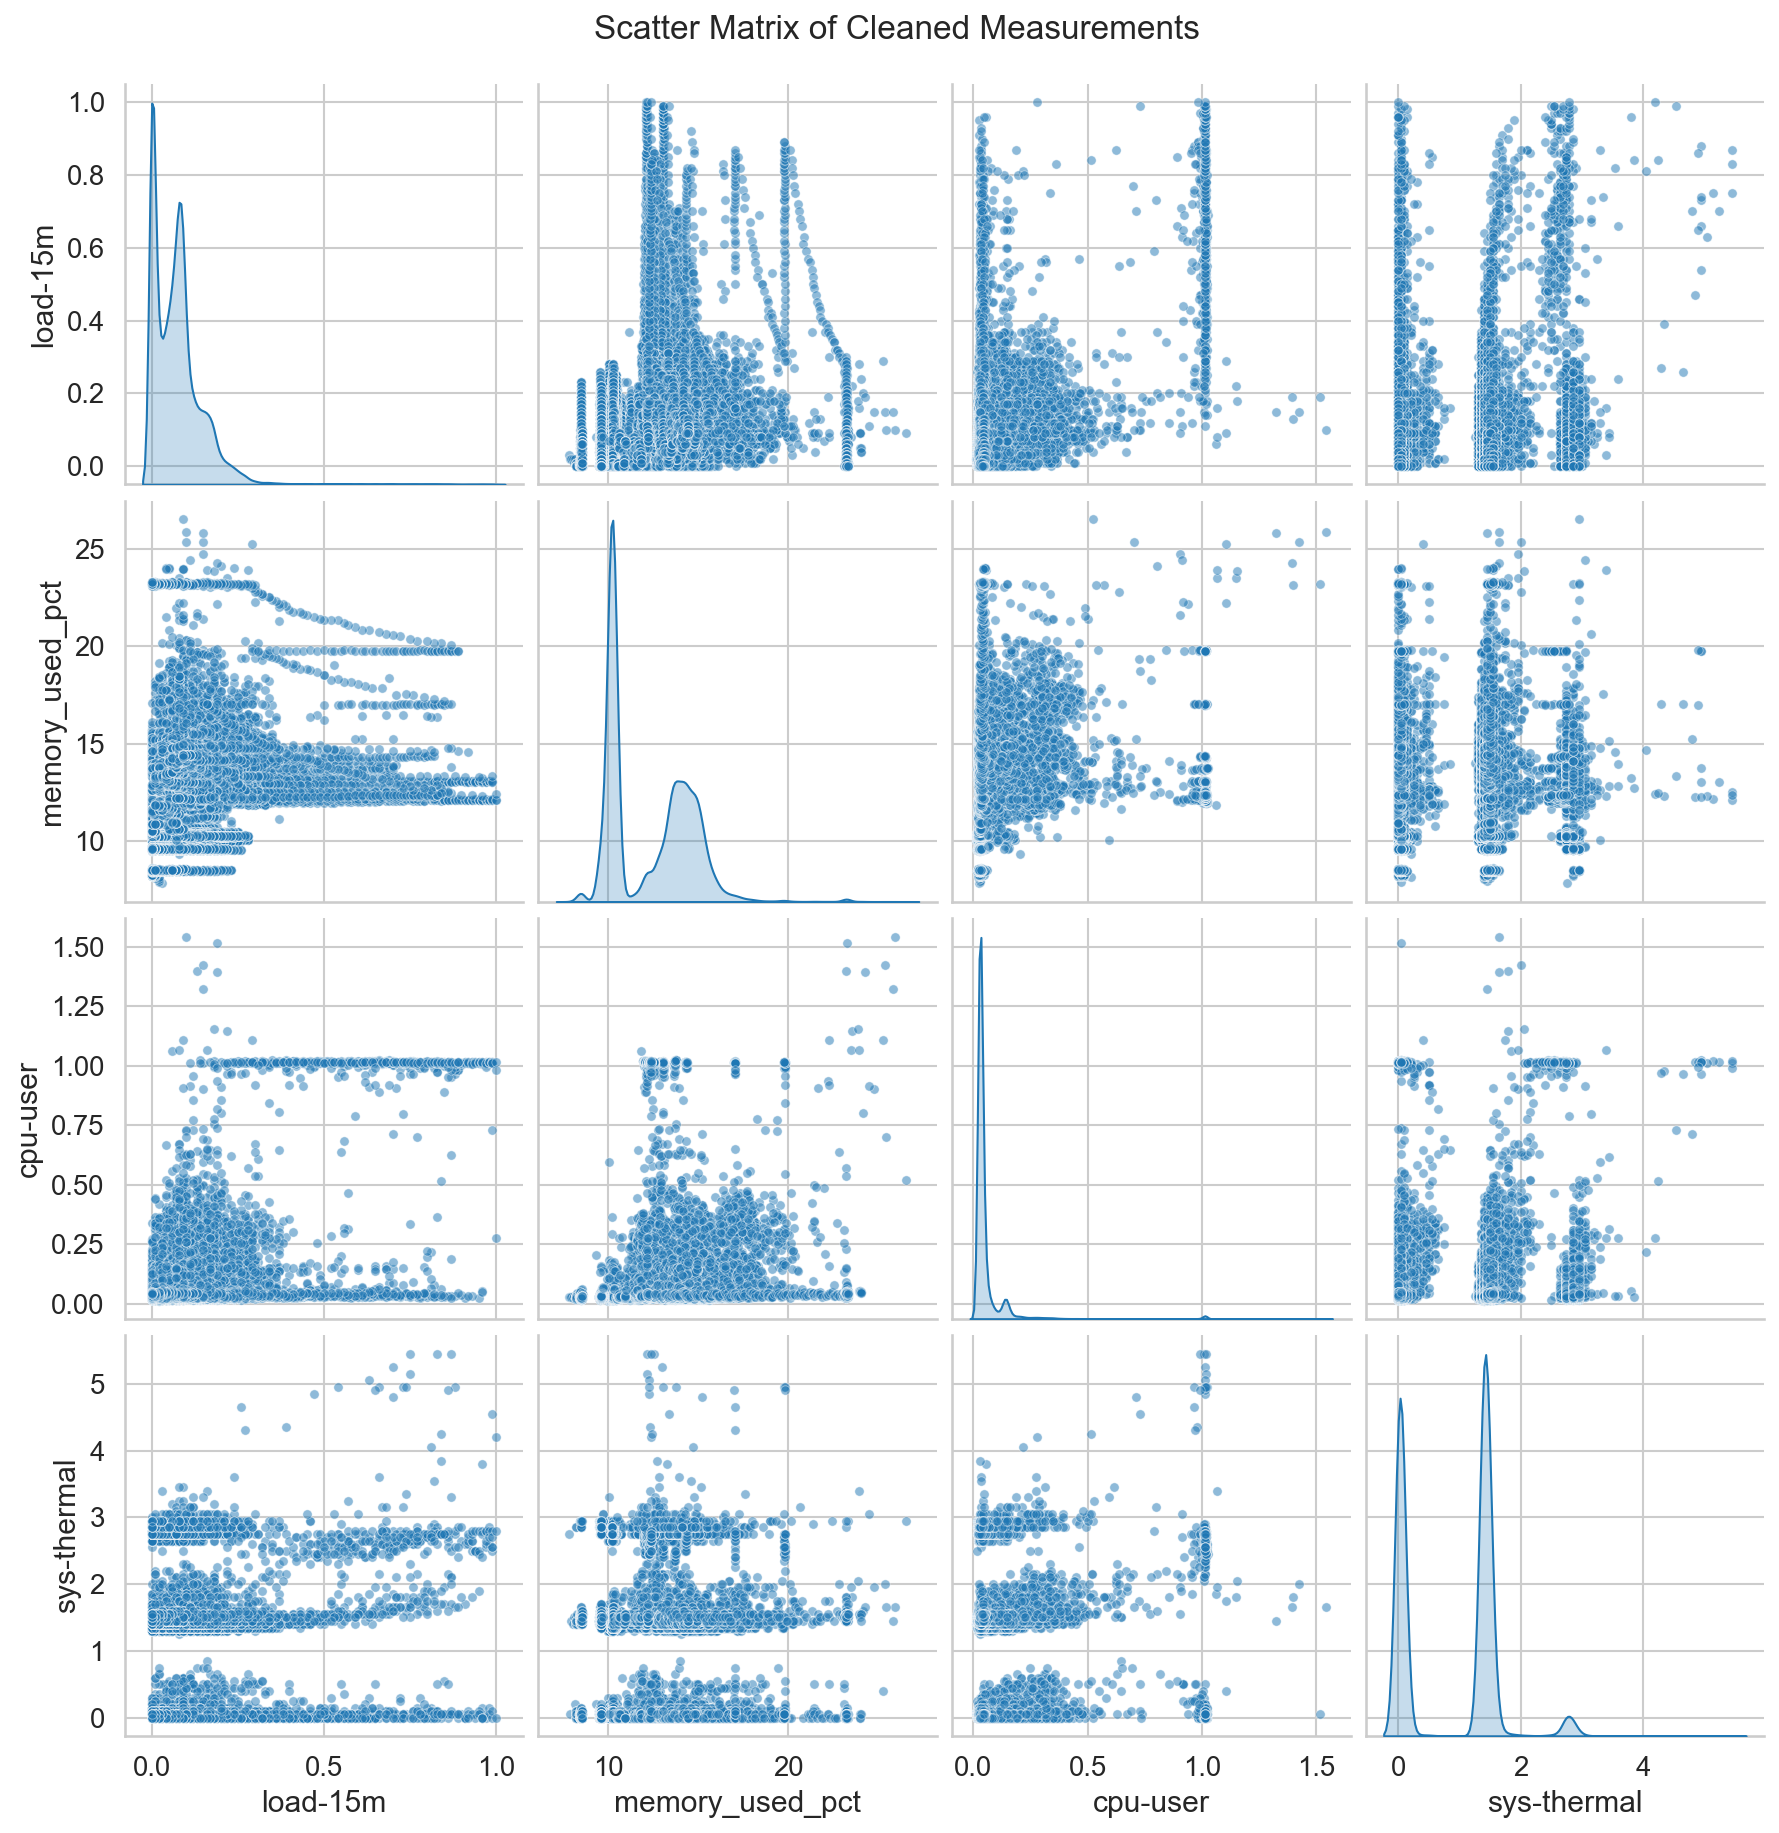

C:\Users\rapha\AppData\Local\Temp\ipykernel_36816\1088537841.py:27: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed in 3.10.
  p.close()


[]

In [5]:
def save_image(filename, figs): 
    """Gathers multiple plt.figure obejcts and outputs thm into a pdf 
    
    Parameters
    ----------
    filename : str
        Path to the directory and name of output .pdf file
    
   
    No Returns
    """
    
    # PdfPages is a wrapper around pdf  
    p = PdfPages(filename) 
      
    # get_fignums Return list of existing figure numbers 
    # fig_nums = plt.get_fignums()   
    # figs = [plt.figure(n) for n in fig_nums] 
      
    # iterating over the numbers in list 
    for fig in figs:  
        
        # and saving the files 
        fig.savefig(p, format='pdf')  
      
    # close the object 
    p.close()   



def visu_raw_data(file_dir: str, file_name: str, df_arg: pd.DataFrame = None) -> plt.figure:
    """Load and visualize filtered test system performance data.
    
    Parameters
    ----------
    file_dir : str
        Path to the CSV data file location (directory)
    file_name : str
        Name of the specified CSV file
    
    optional
    df_arg: pd.DataFrame
        output from load_system_data()

    Additional outputs
    saves visualized data into dir "./visu_raw"
    
    Returns
    -------
    ...
    """
    # Check DataFrame was passed
    if isinstance(df_arg, pd.DataFrame):
        df = df_arg
        # Pdf file name and path -> pd used => no identifier => using "./" 
        pdf_dir = "./"
        pdf_name = "Visu_output_noident.pdf"
        print("Function called with a DataFrame.")
    else:
        # Attempt to read the DataFrame from file
        try:
            file_path = file_dir + file_name
            df = pd.read_csv(file_path, delimiter = ",",usecols=["datetime",
                                                         "load-15m",
                                                         "memory_used_pct",
                                                         "cpu-user",
                                                         "cpu-system",
                                                         "sys-thermal",
                                                         "sys-interrupt-rate",
                                                         "server-up",
                                                         "disk-io-time"])
            print(f"Function called with a file: {file_path}")
            df.set_index('datetime', inplace=True)
            # Pdf file name and path -> path used => use identifier 
            pdf_dir = pathVisuRaw
            pdf_name = file_name.replace('.csv', '.pdf')
        except Exception as e:
            print(f"Error loading the file: {e}")
            return None
    # testing print(df.head())
    
    measurements = {
        "load-15m": ('load-15m', '%'),
        "memory_used_pct": ('memory_used_pct', '%'),
        "cpu-user": ('cpu-user', 'delta-s'),
        "cpu-system": ('cpu-system', 'delta-s'),
        "sys-thermal": ('sys-thermal', 'avg delta-°C/min'),
        "sys-interrupt-rate": ('sys-interrupt-rate', 'delta-s'),
        "disk-io-time": ('disk-io-time', 'delta-s')
    }

    # Time-Series - raw and rolling average
    fig1, axes = plt.subplots(4, 2, figsize=(20, 30))
    fig1.suptitle('Tme-Series - Raw Data', fontsize=16, y=1.02)

    down_data = df[df['server-up'] != 2]

    for i,(measure, (title, unit)) in enumerate(measurements.items()):
        row = i // 2
        col = i % 2
        
        # Plot mean with standard deviation
        df[measure].plot(alpha=0.15,ax=axes[row, col] , label='Raw', color='blue')
        df[measure].rolling(window=12).mean().plot(ax=axes[row, col],label='12-hour moving average', color='green', alpha=0.5)
        
        down_data[measure].plot(ax=axes[row, col] , label='Error', color='red')
        
        axes[row, col].set_title(f'Time-Series of {measure.upper()}')
        axes[row, col].set_xlabel('Datetime')
        axes[row, col].set_ylabel(f'{title} ({unit})')
        axes[row, col].grid(True)
        axes[row, col].legend()
        
    plt.tight_layout()
    #---------------------

    # Daily patterns - Boxplots -missing day/night
    
    df['hour'] = df.index.hour
    
    fig2, axes = plt.subplots(4, 2, figsize=(20, 15))
    fig2.suptitle('Daily patterns - Boxplots and Averages', fontsize=16, y=1.02)

    for i, (measure, (title, unit)) in enumerate(measurements.items()):
        row = i // 2
        col = i % 2
        
        hourly_mean = df.groupby('hour')[measure].agg(['mean'])
        hourly_mean['mean'].plot(
            ax=axes[row, col],
            kind='line',
            color='green'
        )

        df.boxplot(
            ax=axes[row, col],
            column=measure,
            by='hour'
        )
        if(title == 'cpu-user'):
            axes[row, col].set_ylim([0, 0.8])
        axes[row, col].set_title(f'Daily Pattern of {title} ')
        axes[row, col].set_xlabel('Hour of Day')
        axes[row, col].set_ylabel(f'{title} ({unit})')
        axes[row, col].grid(True)
    plt.tight_layout()
    #---------------------

    # Correlation heatmap
    fig3, axes = plt.subplots(1, 1, figsize=(15, 15))
    fig3.suptitle('Correlation', fontsize=16, y=1.02)

    corr_matrix = df[['load-15m', 'memory_used_pct', 'cpu-user', 'cpu-system','sys-thermal', 'sys-interrupt-rate', 'disk-io-time', 'server-up']].corr()
    sns.heatmap(corr_matrix,
                annot=True,      # Show correlation values
                cmap='coolwarm', # Diverging colormap
                center=0,        # Center colormap at 0
                fmt='.2f',       # Format coefficients
                ax=axes)
    axes.set_title('Metric Correlations')
    #---------------------

    fig4, axes = plt.subplots(4, 2, figsize=(20, 30))
    fig4.suptitle('Relationship: Scatter & Hexbin plot', fontsize=24, y=1.02)
        
    # Scatter plots with server status
    scatter = axes[0, 0].scatter(df['cpu-user'], df['memory_used_pct'],
                            c=df['server-up'],  # Color by status
                            cmap='RdYlGn',      # Red-Yellow-Green
                            alpha=0.5)          
    plt.colorbar(scatter, ax=axes[0, 0], label='Server Status')
    axes[0, 0].set_xlabel('CPU Time Rate of Change (s)') 
    axes[0, 0].set_ylabel('Memory Usage (%)') 
    axes[0, 0].set_title('CPU Time vs Memory Usage')

    scatter = axes[1, 0].scatter(df['load-15m'], df['memory_used_pct'],
                            c=df['server-up'],  # Color by status
                            cmap='RdYlGn',      # Red-Yellow-Green
                            alpha=0.5)          
    plt.colorbar(scatter, ax=axes[1, 0], label='Server Status')
    axes[1, 0].set_xlabel('System load over the last 15 minutes (%)') 
    axes[1, 0].set_ylabel('Memory Usage (%)') 
    axes[1, 0].set_title('System Load vs Memory Usage')

    scatter = axes[2, 0].scatter(df['load-15m'], df['cpu-user'],
                            c=df['server-up'],  # Color by status
                            cmap='RdYlGn',      # Red-Yellow-Green
                            alpha=0.5)          
    plt.colorbar(scatter, ax=axes[2, 0], label='Server Status')
    axes[2, 0].set_xlabel('System load over the last 15 minutes (%)') 
    axes[2, 0].set_ylabel('CPU Time Rate of Change (s)') 
    axes[2, 0].set_title('System Load vs Memory Usage')

    scatter = axes[3, 0].scatter(df['load-15m'], df['sys-thermal'],
                            c=df['server-up'],  # Color by status
                            cmap='RdYlGn',      # Red-Yellow-Green
                            alpha=0.5)          
    plt.colorbar(scatter, ax=axes[3, 0], label='Server Status')
    axes[3, 0].set_xlabel('System load over the last 15 minutes (%)') 
    axes[3, 0].set_ylabel('System thermal change (delta-°C/min)') 
    axes[3, 0].set_title('System Load vs System Thermals')
    #--------------------- 

    # Hexbin for density
    df.plot.hexbin(x='cpu-user', y='memory_used_pct',
                gridsize=100,
                cmap='YlOrRd',
                ax=axes[0, 1])
    axes[0, 1].set_title('CPU Time vs Memory Usage')
    #axes[0, 1].set_xlim([-0.025, 0.4])
    #axes[0, 1].set_ylim([4, 9])

    df.plot.hexbin(x='load-15m', y='memory_used_pct',
                gridsize=100,
                cmap='YlOrRd',
                ax=axes[1, 1])
    axes[1, 1].set_title('System Load vs Memory Usage')
    #axes[1, 1].set_xlim([-0.05, 0.3])
    #axes[1, 1].set_ylim([3.5, 9])

    df.plot.hexbin(x='load-15m', y='cpu-user',
                gridsize=100,
                cmap='YlOrRd',
                ax=axes[2, 1])
    axes[2, 1].set_title('System Load vs CPU Time')
    #axes[2, 1].set_xlim([-0.015, 0.3])
    #axes[2, 1].set_ylim([-0.075, 0.4])

    df.plot.hexbin(x='load-15m', y='sys-thermal',
                gridsize=100,
                cmap='YlOrRd',
                ax=axes[3, 1])
    axes[3, 1].set_title('System Load vs System Thermals')
    #axes[3, 1].set_xlim([-0.025, 0.3])
    #axes[3, 1].set_ylim([-0.25, 2])
    plt.tight_layout()
    #---------------------

    measure = ['load-15m', 'memory_used_pct', 'cpu-user', 'sys-thermal']

    # Get data without duplicates by taking mean for each timestamp
    df_plot = df.groupby(df.index)[measure].mean()

    try:
        sns.pairplot(
            data=df_plot,
            diag_kind='kde',
            plot_kws={'alpha': 0.5, 's': 20},
            height=3
        )
        plt.suptitle('Scatter Matrix of Cleaned Measurements', y=1.02, fontsize=16)
        plt.show()
    except Exception as e:
        print(f"Warning: Could not create scatter matrix plot: {str(e)}")

    fig_nums = plt.get_fignums()   
    figs = [plt.figure(n) for n in fig_nums]

    #function to output pdf 
    save_image(pdf_dir+pdf_name, figs)
    plt.close("all")
    return figs

#visu_raw_data(pathFilter,files[-1],None)
visu_raw_data(None,None,this)

